# Load-in some dependent packages and the codes

In [1]:
################## dependent packages ##################
library(matrixStats)  # dependent for MixCenMVReg_EM.R & MixCenUVReg_EM.R
library(condMVNorm)   # dependent for MixCenMVReg_EM.R
library(MomTrunc)     # dependent for MixCenMVReg_EM.R

library(truncnorm)    # dependent for MixCenUVReg_EM.R
########################################################



################### Other useful packages ##############
library(tidyverse) # For data manipulation and plots
library(ggpubr)    # For stacking multiple plots
########################################################



################### Load-in the codes ##################
path=getwd()

source(paste0(path,"/MixCenMVReg_EM.R")) # For multivariate responses (dimenstion of Y>1)
source(paste0(path,"/MixCenUVReg_EM.R")) # For univariate responses (dimenstion of Y=1)
source(paste0(path,"/Util_Func.R"))      # For all dependent functions used in the EM algorithms


Loading required package: mvtnorm

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::count()  masks matrixStats::count()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Generation of a toy data

First, we just need to generate a toy data of bivariate responses ($Y_1, Y_2$) and an univariate covariate ($X_1$) with maybe 3 clusters each with different winthin-cluster effects.

Therefore, we need to have a list of three ${2\times 2}$ $\beta$ matrices to denote the different intercepts of ($Y_1, Y_2$) and effects of X for all three clusters.

Also, we need a list of three ${2\times 2}$ $\Sigma$ matrices that are symmetric positive-definite to denotethe noise covariances.


Let's not worry about the censoring, so first thing here is to define some parameters. Here, we assume that the three clusters are with mixing porportions of 10%, 70%, 20%:

In [2]:
set.seed(22) # define the random seed here in case we forget to do so.

BETA=list(matrix(c(2,0,20,-2),nrow=2,ncol=2),
          matrix(c(3,1,25,-3),nrow=2,ncol=2),
          matrix(c(3.5,2,30,-5),nrow=2,ncol=2))

SIGMA=list(matrix(c(1,0.1,0.1,1),nrow=2,ncol=2),
           matrix(c(2,0.2,0.2,0.5),nrow=2,ncol=2),
           matrix(c(0.5,0.3,0.3,2),nrow=2,ncol=2))                          
PIE=c(.1,.7,.2)

message("A vector of Mixing porportions: ")
print(PIE)

message("A list of Beta matrices: ")
print(BETA)

message("A list of Sigma matrices: ")
print(SIGMA)

A vector of Mixing porportions: 



[1] 0.1 0.7 0.2


A list of Beta matrices: 



[[1]]
     [,1] [,2]
[1,]    2   20
[2,]    0   -2

[[2]]
     [,1] [,2]
[1,]    3   25
[2,]    1   -3

[[3]]
     [,1] [,2]
[1,]  3.5   30
[2,]  2.0   -5



A list of Sigma matrices: 



[[1]]
     [,1] [,2]
[1,]  1.0  0.1
[2,]  0.1  1.0

[[2]]
     [,1] [,2]
[1,]  2.0  0.2
[2,]  0.2  0.5

[[3]]
     [,1] [,2]
[1,]  0.5  0.3
[2,]  0.3  2.0



Now, we need to define a function to generate a toy dataset with, say, n=1,000. We don't need to worry about replications for simulation for now. At this moment, let's just set the replication to be one time. But we can write the function in a general way for generating multiple repilcations

In [3]:
TrueDataGen=function(Replicate=30, n=1000,pie,beta,sigma){
    
            N=n

            G=length(pie) # Num of Clusters
            P=dim(beta[[1]])[2] # Dimension of Y
            D=dim(beta[[1]])[1] # Dimension of X (intercpt included)

            out=list()
                for(i in 1:Replicate){
                    df_X=list()
                    for(g in 1:G){
                        df_X[[g]]=cbind(rep(1,pie[g]*N),do.call('cbind',lapply(rep(pie[g]*N,1),rnorm,0)))
                    }


                    mu=list()
                    for(g in 1:G){
                        mu[[g]]=df_X[[g]]%*%beta[[g]]
                    }


                    df_Y=list()
                    for(g in 1:G){
                        df_Y[[g]]=as.data.frame(mu[[g]]+rmvnorm(pie[g]*N,mean=rep(0,P),sigma=sigma[[g]]))
                        colnames(df_Y[[g]])=paste(rep('Y',P),1:P, sep = "", collapse = NULL)
                        df_Y[[g]]$True_label=g
                    }

                    df_X=do.call('rbind',df_X)
                    colnames(df_X)=paste(rep('X',D),1:D-1, sep = "", collapse = NULL)

                    df_Y=do.call('rbind',df_Y)
                    df_Labels=as.factor(df_Y$True_label)
                    df_Y=as.matrix(df_Y[,1:P])


                    df=list(df_Y,df_X,df_Labels)
                    names(df)=c('Y','X','Labels')

                    out[[i]]=df
                }

                return(out)

            }


Then, we can generate the data using our defined parameters and store the true parameters for later use:

In [4]:
example_true_pars=list(PIE,BETA,SIGMA)
names(example_true_pars)=c('PIE','BETA','SIGMA')
save(example_true_pars,file = "example_true_pars.RData")

example_true=TrueDataGen(1,1000,PIE,BETA,SIGMA)

We can visulize the generated data:

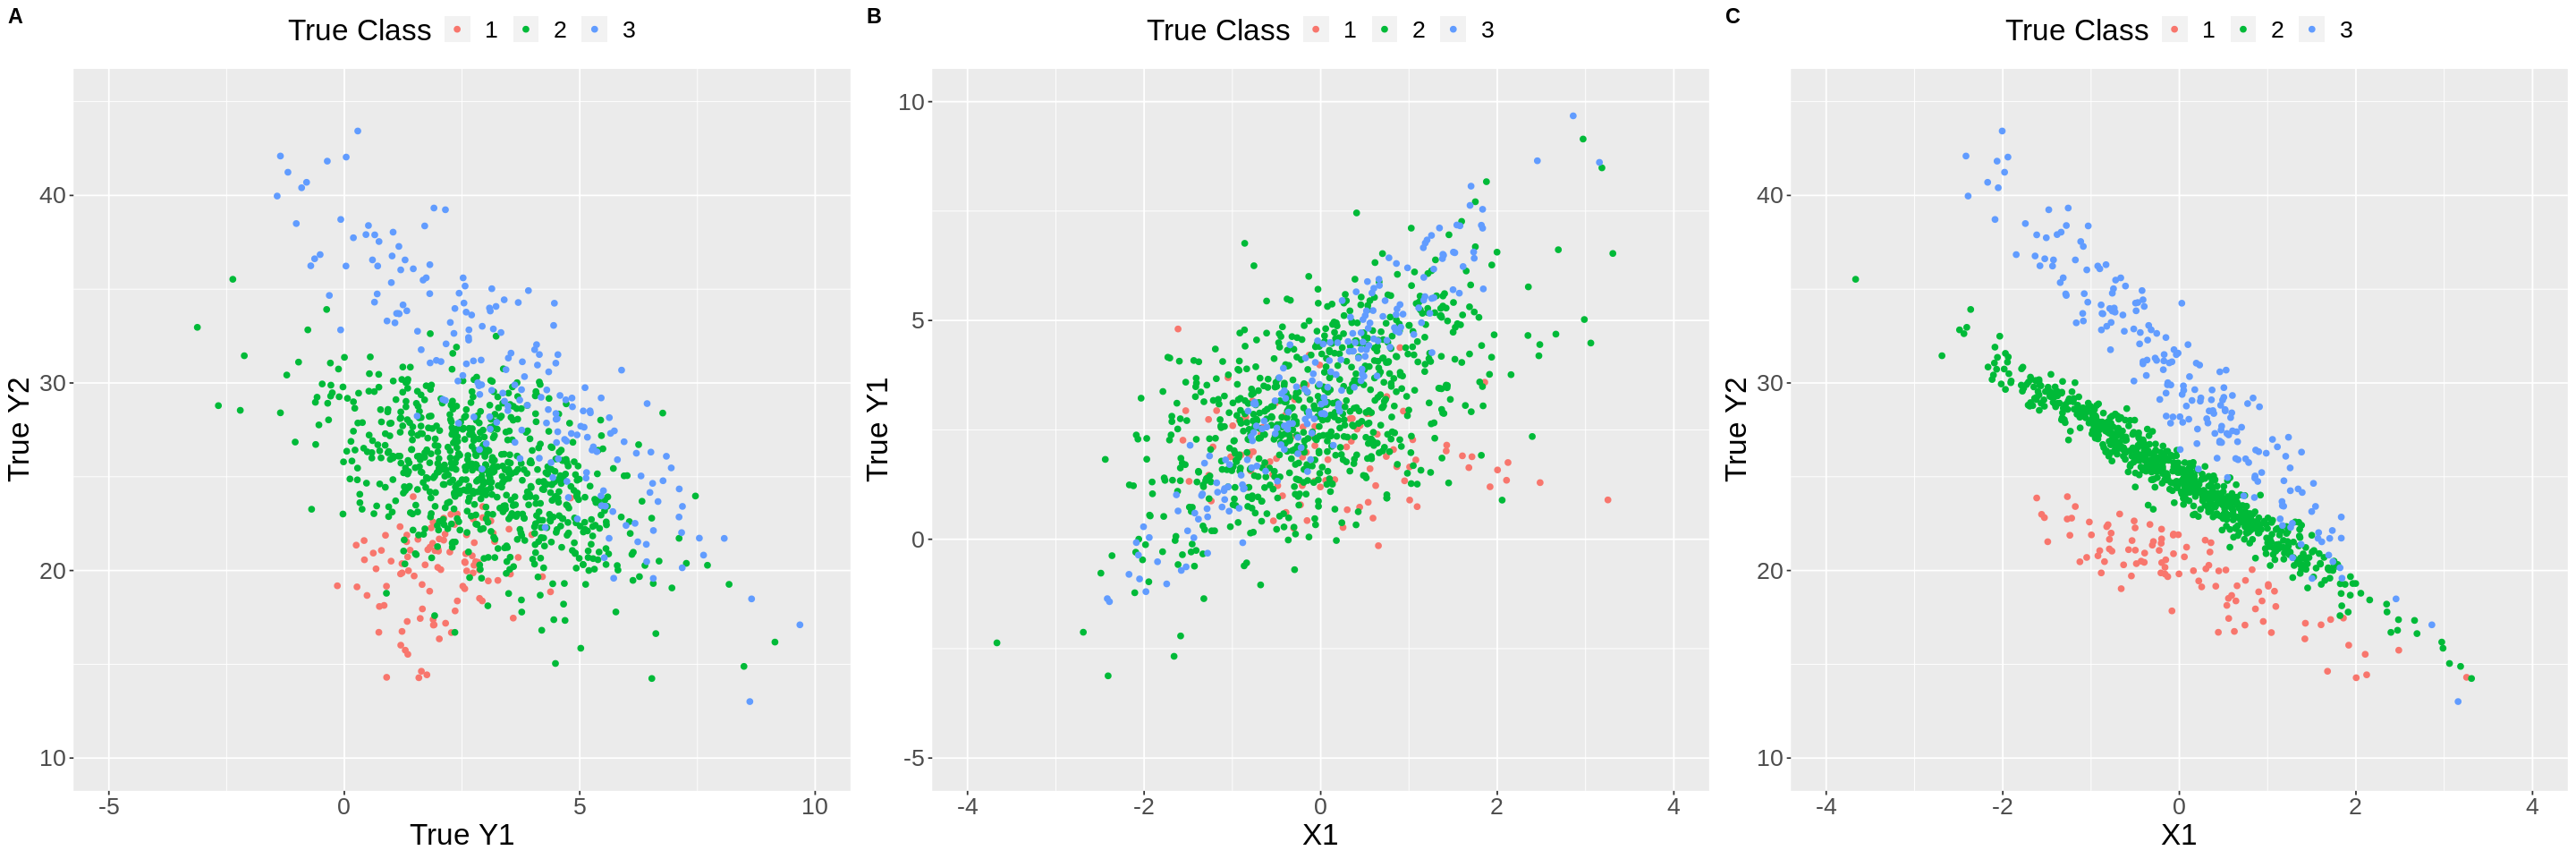

In [5]:
################### Store the default ploting pars###########
defaultW=getOption("warn")
options(warn = -1)


defaultplotw=getOption("repr.plot.width")
defaultploth=getOption("repr.plot.height")
#############################################################


data=example_true[[1]]
data=cbind(data$Y,data$X,data$Labels)
colnames(data)[5]='Labels'
data=as.data.frame(data)

p1=ggplot(data, aes(x=Y1, y=Y2, color=as.factor(Labels))) +
   geom_point() + scale_color_discrete(name = "True Class")+xlab("True Y1")+ylab("True Y2")+
   lims(x= c(-5,10), y = c(10, 45))+theme(legend.position = "top",text = element_text(size = 20))



p2=ggplot(data, aes(x=X1, y=Y1, color=as.factor(Labels))) +
   geom_point() + scale_color_discrete(name = "True Class")+ylab("True Y1")+
   lims(x= c(-4,4), y = c(-5,10))+theme(legend.position = "top",text = element_text(size = 20))



p3=ggplot(data, aes(x=X1, y=Y2, color=as.factor(Labels))) +
   geom_point() + scale_color_discrete(name = "True Class")+ylab("True Y2")+
   lims(x= c(-4,4), y = c(10,45))+theme(legend.position = "top",text = element_text(size = 20))


# p1
# p2
# p3

options(repr.plot.width=24, repr.plot.height=8)

ggarrange(p1,p2,p3, 
          labels = c("A","B","C"),
          ncol = 3, nrow = 1)

options(warn = defaultW)
options(repr.plot.width=defaultplotw, repr.plot.height=defaultploth)

We see that even given the true data before censoring. it would be hard to only cluster them on the repsonese ($Y_1, Y_2$) if we ignore the covariate ($X_1$).


Now, we can apply censoring, by first define some detection limits for ($Y_1, Y_2$). 


Let's say, $Y_1$ can be only observed between 2.5 and 9; $Y_2$ can be only observed between 5 and 26.5

In [6]:
# Define detection limits
DL=list(c(2.5,10),
        c(0,26.5))

Then by writing the below function, we can censore ($Y_1, Y_2$) subject to the detection limit we defined

In [7]:
CensDataGen=function(True_Data,dl){
    Replicate=length(True_Data)

    for(r in 1:Replicate){
        df_Y=True_Data[[r]]$Y
        N=dim(df_Y)[1]
        P=dim(df_Y)[2]

        censorID=matrix(rep(0,N*P),nrow=N,ncol=P)
        colnames(censorID)=paste(rep('C',P),1:P, sep = "", collapse = NULL)
        
        for(i in 1:N){
            for(d in 1:P){
                if(df_Y[i,d]<=dl[[d]][1]){
                    df_Y[i,d]=dl[[d]][1]
                    censorID[i,d]=-1
                }else{
                    if(df_Y[i,d]>=dl[[d]][2]){
                        df_Y[i,d]=dl[[d]][2]
                        censorID[i,d]=1
                    }
                }
            }
        }
        True_Data[[r]]$Y=df_Y
        True_Data[[r]]$censorID=censorID
    }
        
    return(True_Data)
}

example_censored=CensDataGen(example_true,DL)

Similarly, we can visualize the censored data:

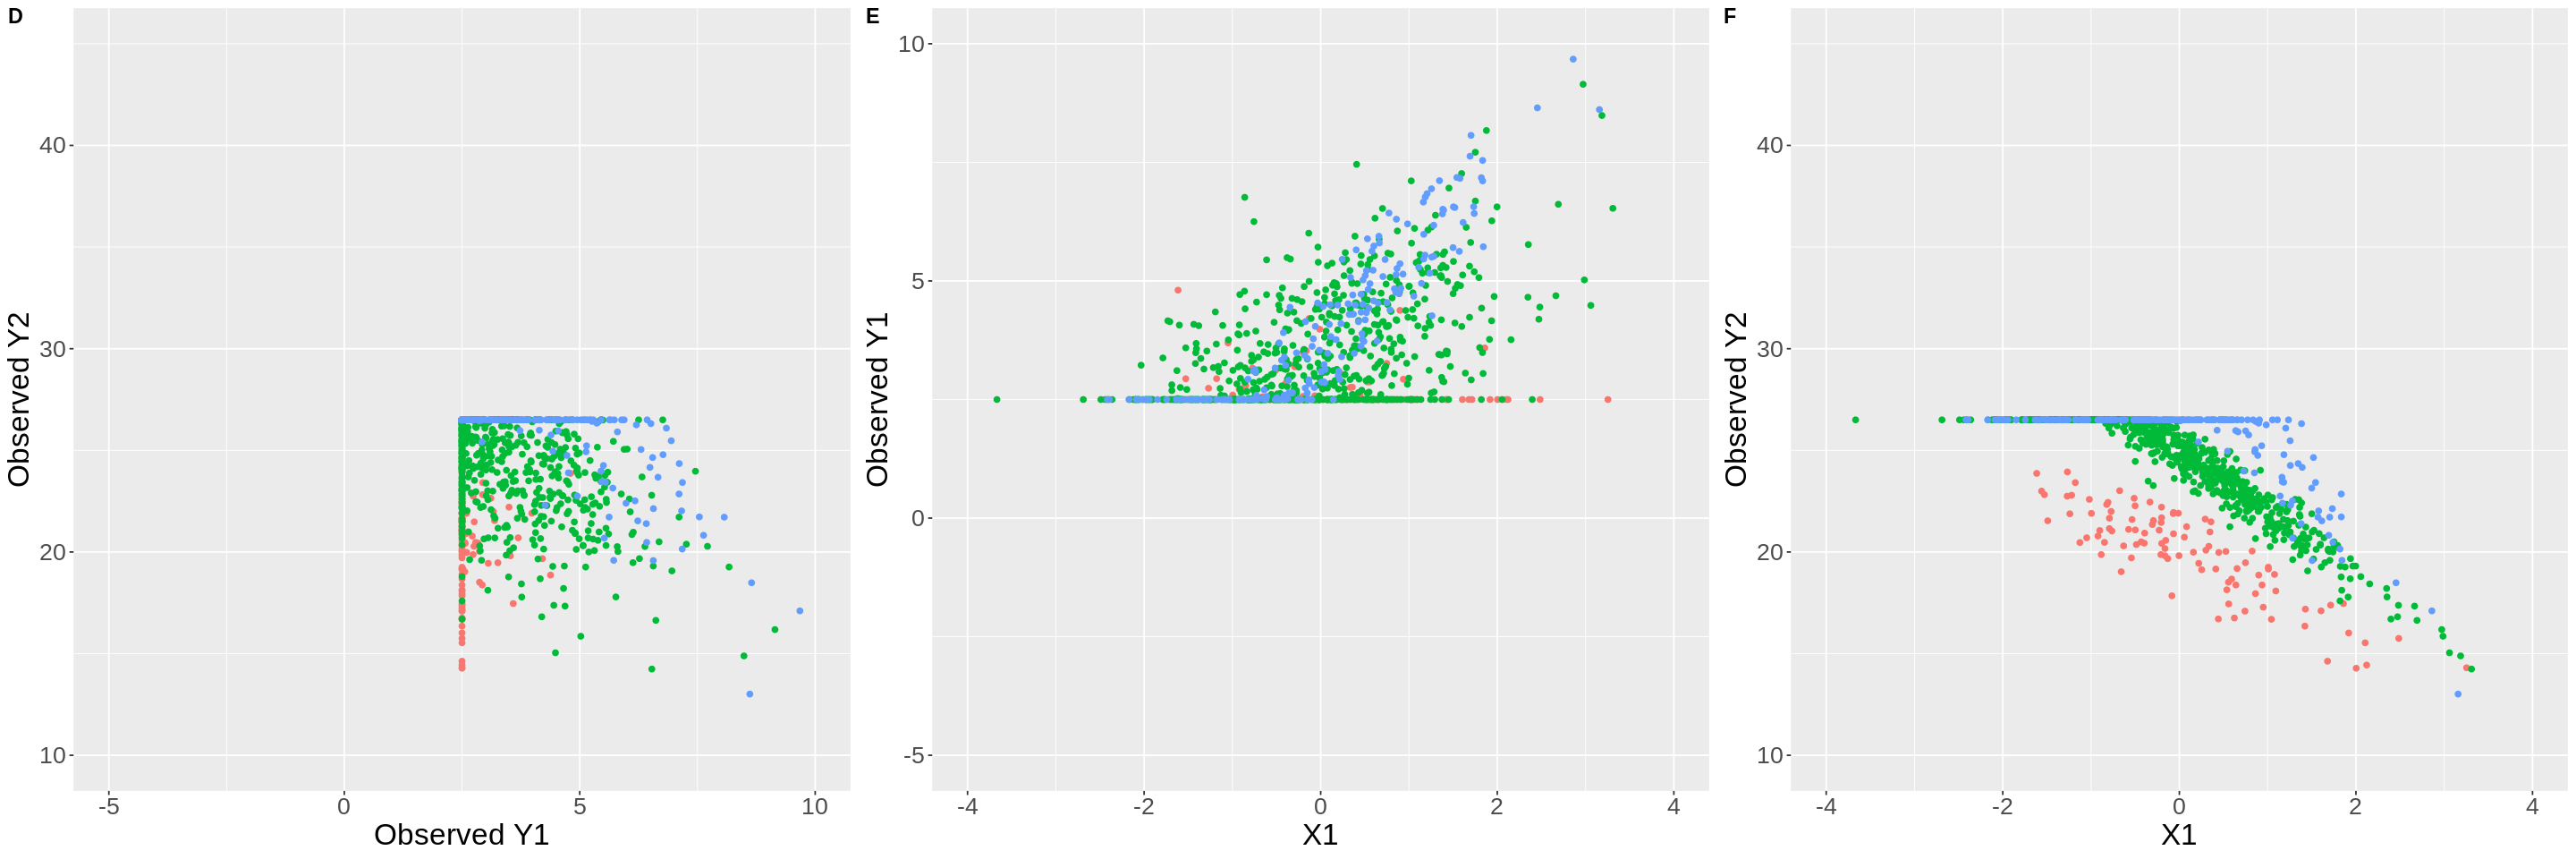

In [8]:
data=example_censored[[1]]
data=cbind(data$Y,data$X,data$Labels)
colnames(data)[5]='Labels'
data=as.data.frame(data)

p4=ggplot(data, aes(x=Y1, y=Y2, color=as.factor(Labels))) +
   geom_point() + scale_color_discrete(name = "True Class")+xlab("Observed Y1")+ylab("Observed Y2")+
   lims(x= c(-5,10), y = c(10, 45))+theme(legend.position = "none",text = element_text(size = 20))


p5=ggplot(data, aes(x=X1, y=Y1, color=as.factor(Labels))) +
   geom_point() + scale_color_discrete(name = "True Class")+ylab("Observed Y1")+
   lims(x= c(-4,4), y = c(-5,10))+theme(legend.position = "none",text = element_text(size = 20))


p6=ggplot(data, aes(x=X1, y=Y2, color=as.factor(Labels))) +
   geom_point() + scale_color_discrete(name = "True Class")+ylab("Observed Y2")+
   lims(x= c(-4,4), y = c(10,45))+theme(legend.position = "none",text = element_text(size = 20))

options(repr.plot.width=24, repr.plot.height=8)

ggarrange(p4,p5,p6, 
          labels = c("D","E","F"),
          ncol = 3, nrow = 1)

options(warn = defaultW)
options(repr.plot.width=defaultplotw, repr.plot.height=defaultploth)

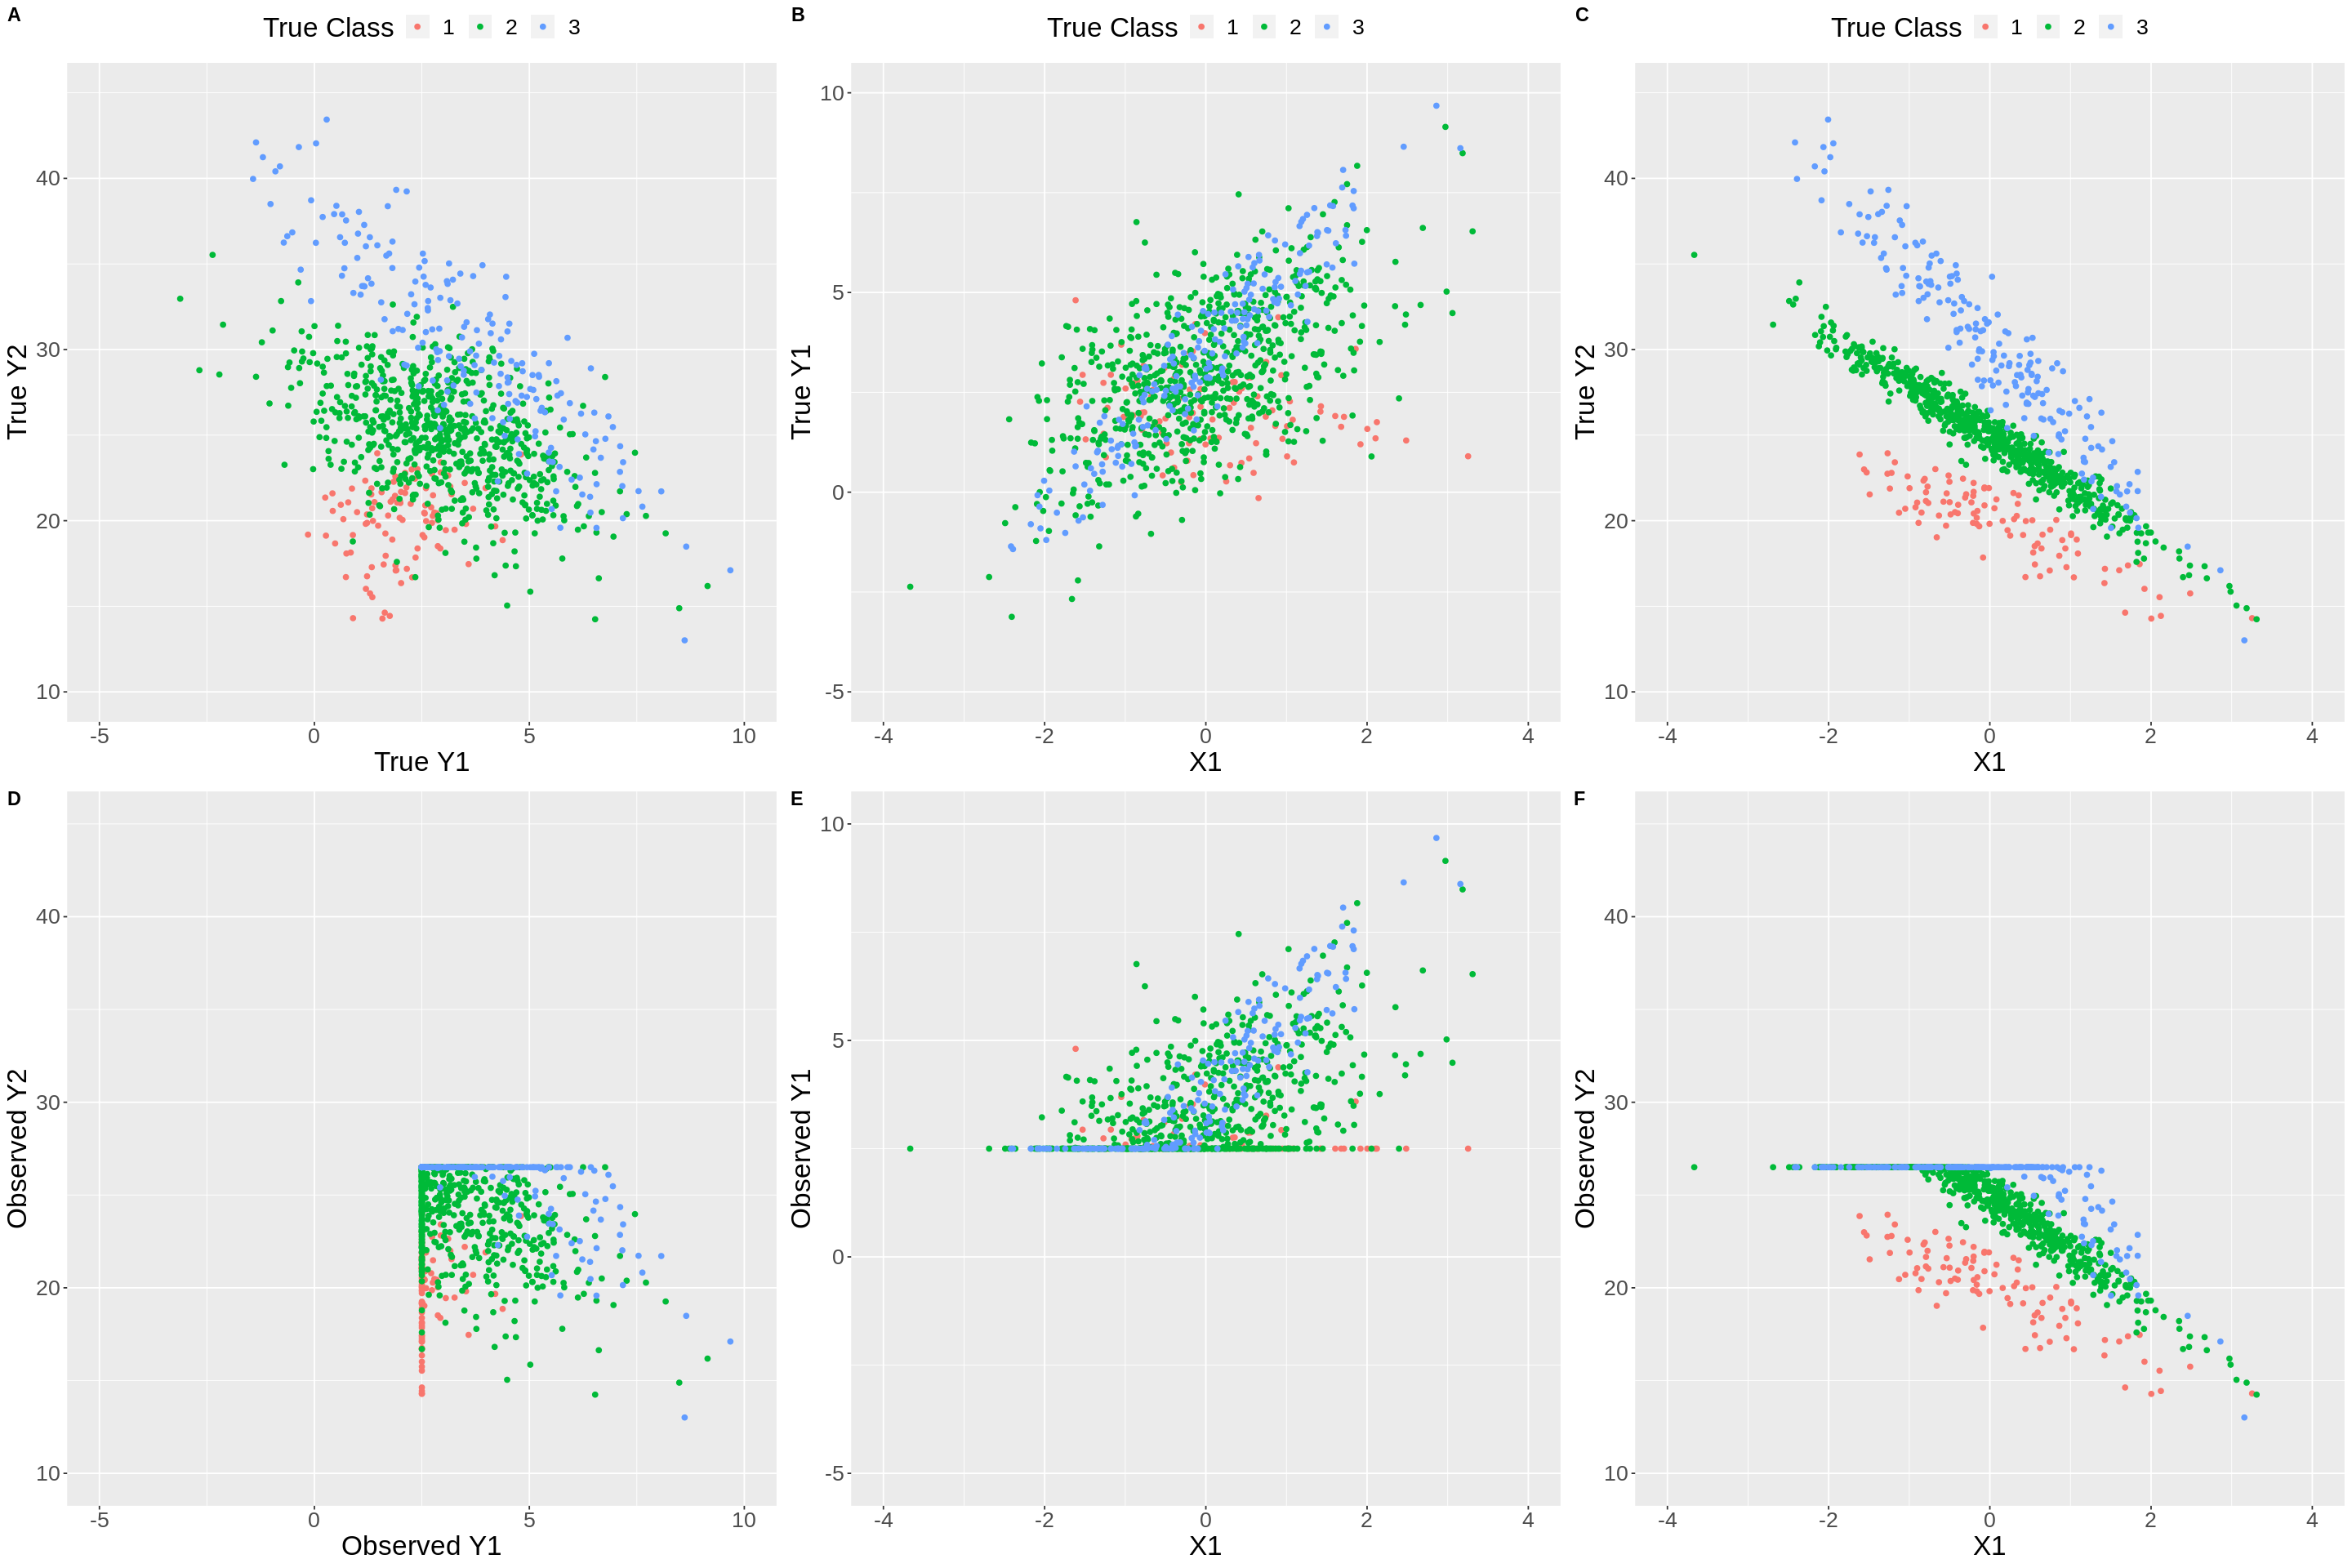

In [9]:
options(repr.plot.width=24, repr.plot.height=16)

ggarrange(p1,p2,p3,p4,p5,p6, 
          labels = c("A","B","C","D","E","F"),
          ncol = 3, nrow = 2)

options(warn = defaultW)
options(repr.plot.width=defaultplotw, repr.plot.height=defaultploth)

Now, we we can calculate the censoring rates of ($Y_1, Y_2$) and store the ture data and the censored data for later use

In [10]:
CensorRate=function(data){
    censor_rate=matrix(rep(NA,length(data)*2),nrow=length(data),ncol=2)

    for(i in 1:length(data)){
        censorID=data[[i]]$censorID
        censor_rate[i,]=c(sum(censorID[,1]!=0)/1000, sum(censorID[,2]!=0)/1000)

    }
    return(apply(censor_rate,2,mean))
}

censrate=CensorRate(example_censored)
names(censrate)=c("Y1","Y2")
print("censoring rate: ")
print(censrate)

example_true=example_true[[1]]
example_censored=example_censored[[1]]

save(example_true,file = "example_true.RData")
save(example_censored,file = "example_censored.RData")

[1] "censoring rate: "
   Y1    Y2 
0.403 0.367 


# Modeling using MixCensMVReg_EM.R

Now we can run our model under different ways to initialize the EM algorithm:

## Initialize from a given parameter setting

Let's initalize from the true parameters, so we expect the coverged estimates are going to be close to our true parameters.

Also, we can store and pass the model results to a variable and let the "print=TURE" argument only give us important info:

[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 10"
[1] "Convergence = TRUE"
[1] "LogLik = -2568.644"
     pie1      pie2      pie3 
0.1055041 0.7017313 0.1927646 
$beta1
           Y1       Y2
X0  1.9929312 20.22026
X1 -0.3095638 -1.92509

$beta2
          Y1        Y2
X0 3.0177890 24.984099
X1 0.9178073 -3.017309

$beta3
         Y1        Y2
X0 3.570595 30.284829
X1 1.914615 -4.943377

$sigma1
          Y1        Y2
Y1 0.9307757 0.1119727
Y2 0.1119727 1.4416285

$sigma2
          Y1        Y2
Y1 1.8952608 0.1406214
Y2 0.1406214 0.4350703

$sigma3
          Y1        Y2
Y1 0.5025928 0.2717128
Y2 0.2717128 2.0586493



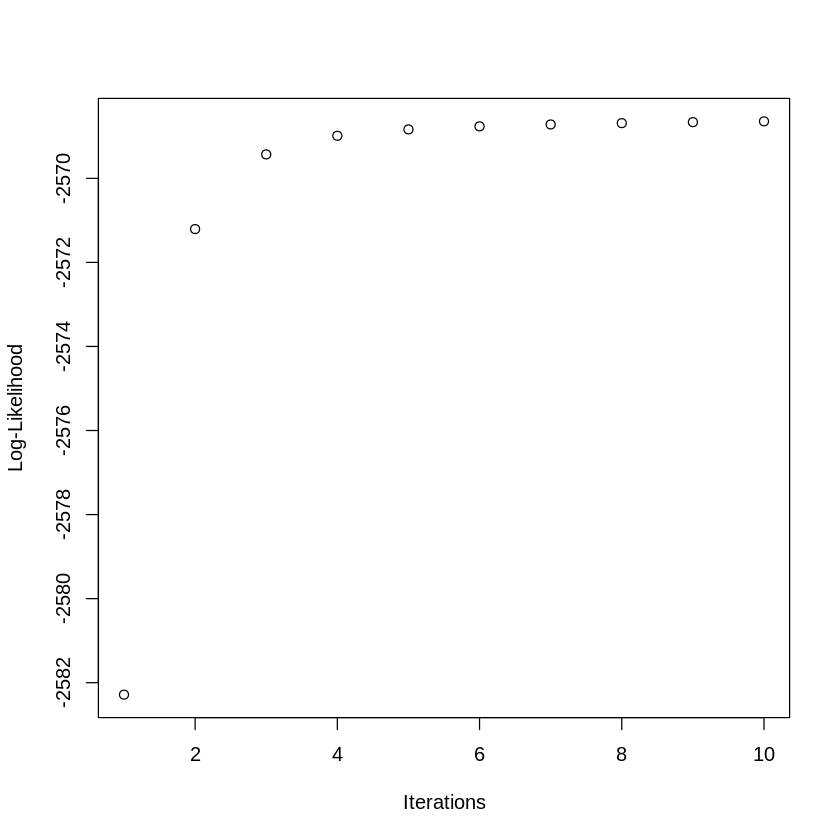

In [11]:
# Note in this case we do not need to set the number of components G=
# The algorithm will run as long as the length of the inital parameters agree.
# Note how the estimated pies are similar to (0.1,0.7,0.2)
testMV1=MixCenMVReg_EM(Y=example_censored$Y,
                       X=example_censored$X,
                       C=example_censored$censorID, 
                       pie_hat=PIE, beta_hat=BETA, sigma_hat=SIGMA,
                       Max.iter=1000, diff.tol=1e-2, print=T)

However, if we ignore the censoring by assuming all observations are uncensord, though it will be faster for computation, we will have a problem:

EM stopped becaused of degenerating solution!



[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 14"
[1] "Convergence = FALSE"
[1] "LogLik = -62.283"
     pie1      pie2      pie3 
0.4029664 0.4048772 0.1921564 
$beta1
              Y1       Y2
X0  2.500000e+00 23.46559
X1 -4.163336e-16 -2.17759

$beta2
          Y1        Y2
X0 3.7442189 24.702227
X1 0.4352384 -2.533069

$beta3
         Y1        Y2
X0 4.102785 24.514424
X1 1.401262 -1.336192

$sigma1
              Y1            Y2
Y1  6.763229e-31 -5.358460e-18
Y2 -5.358460e-18  3.584297e+00

$sigma2
           Y1         Y2
Y1 0.76648557 0.01606221
Y2 0.01606221 0.93489510

$sigma3
          Y1        Y2
Y1 0.7889714 0.1714495
Y2 0.1714495 6.3546917



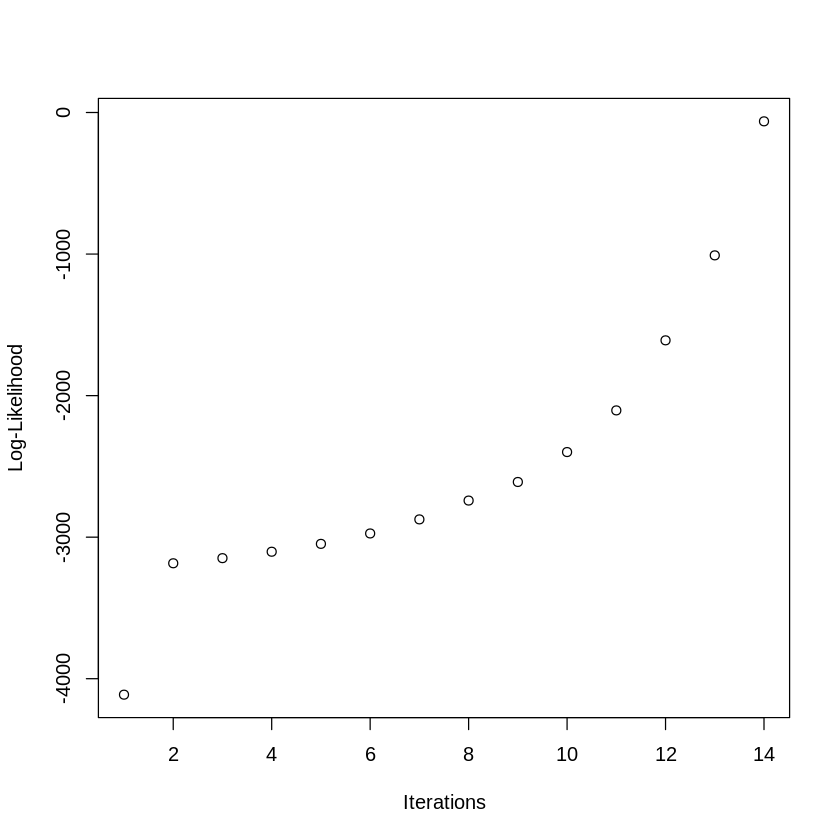

In [12]:
# Note in this case set the censoring 
# Note how the esimated mixing porportions are different than 'testMV1'
# ,even with the true parameter initialization (0,1,0.7,0.2)
# and most importantly we have a degenerated solution with one diagnal element of $sigma1 -->0
testMV1.2=MixCenMVReg_EM(Y=example_censored$Y,
                         X=example_censored$X,
                         C=example_censored$censorID*0, 
                         pie_hat=PIE, beta_hat=BETA, sigma_hat=SIGMA,
                         Max.iter=1000, diff.tol=1e-2, print=T)

Even with the true parameter initialization, the estimated mixing porportions are so different than $(0,1,0.7,0.2)$. Note how the first mixing proportion is close to the censoring rate of $Y_1$ (40.3%) and most importantly we have a degenerated solution with one diagnal element of $\Sigma_1\to0$:

In [13]:
testMV1.2$Sigma$sigma1

,Y1,Y2
Y1,6.763229e-31,-5.358460e-18
Y2,-5.358460e-18,3.584297e+00


This is because when we ignore the censoring, the stacking observations at the detection limit will be recognized as a 'cluster', and because its all with the same values, it will result in a degenerating solution. However, we can use the true uncensored observations to train the model:

[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 5"
[1] "Convergence = TRUE"
[1] "LogLik = -3536.404"
     pie1      pie2      pie3 
0.1052765 0.6970319 0.1976916 
$beta1
           Y1        Y2
X0  2.0125614 20.209784
X1 -0.1755515 -1.898728

$beta2
          Y1        Y2
X0 3.0120095 24.966210
X1 0.9751225 -2.981809

$beta3
         Y1        Y2
X0 3.490737 30.223757
X1 1.995319 -4.910726

$sigma1
          Y1        Y2
Y1 0.8836191 0.1044103
Y2 0.1044103 1.4235160

$sigma2
          Y1        Y2
Y1 1.9161096 0.1955539
Y2 0.1955539 0.4364091

$sigma3
          Y1       Y2
Y1 0.5023918 0.368388
Y2 0.3683880 2.365872



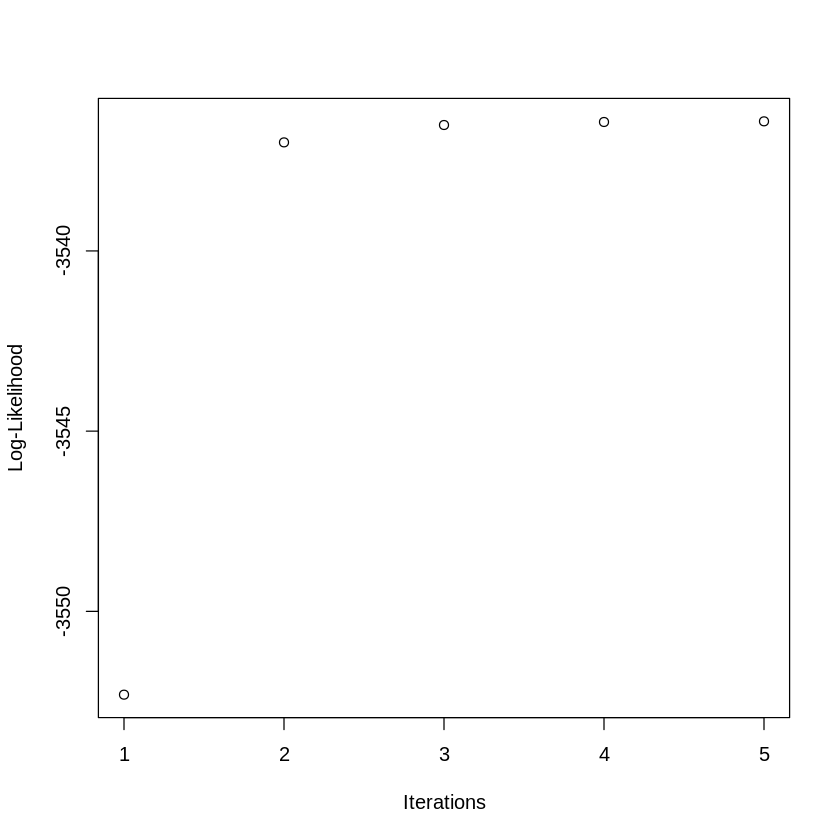

In [14]:
# Only thing change here is that we are using 'example_true' for the responses
# So we dont have any censoring, we can let the C=0 for all observations
testMV1.3=MixCenMVReg_EM(Y=example_true$Y,
                         X=example_censored$X,
                         C=example_censored$censorID*0, 
                         pie_hat=PIE, beta_hat=BETA, sigma_hat=SIGMA,
                         Max.iter=1000, diff.tol=1e-2, print=T)

## initialize from a random initialization

We can start from a random partition, by just letting G=3, notice how this is different from the previous solution:

[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 99"
[1] "Convergence = TRUE"
[1] "LogLik = -2568.654"
     pie1      pie2      pie3 
0.1938343 0.7006492 0.1055166 
$beta1
         Y1        Y2
X0 3.578944 30.274055
X1 1.903271 -4.945075

$beta2
          Y1        Y2
X0 3.0156666 24.982443
X1 0.9175167 -3.016012

$beta3
           Y1       Y2
X0  1.9883649 20.22047
X1 -0.3116429 -1.92505

$sigma1
          Y1        Y2
Y1 0.5036232 0.2764814
Y2 0.2764814 2.1119332

$sigma2
          Y1        Y2
Y1 1.8981083 0.1398725
Y2 0.1398725 0.4338175

$sigma3
          Y1       Y2
Y1 0.9387079 0.112630
Y2 0.1126300 1.441945



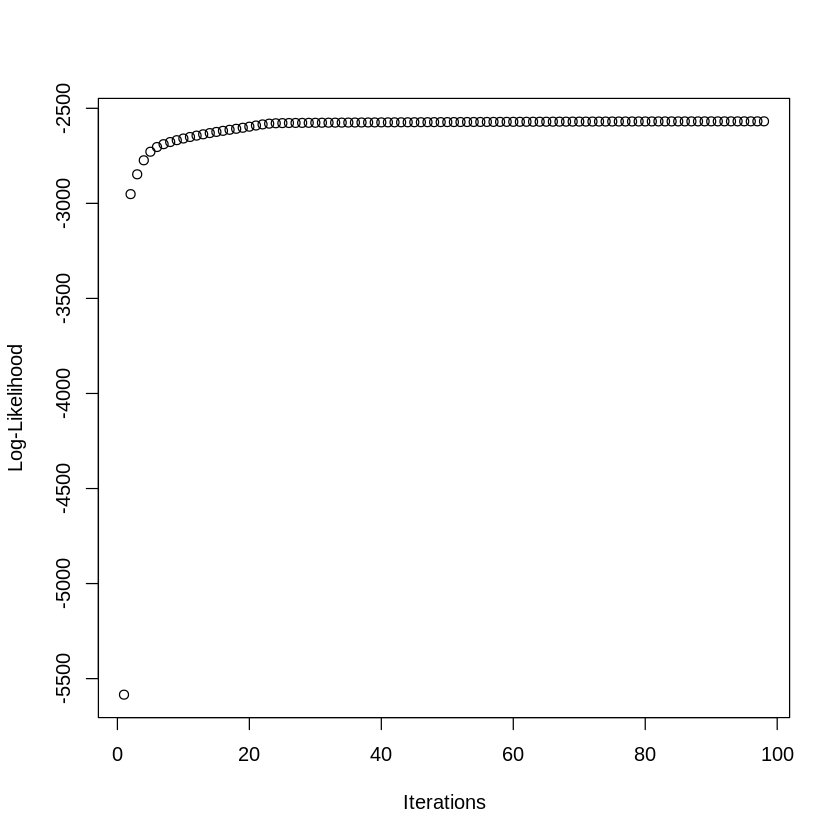

In [15]:
set.seed(1234) 

testMV2=MixCenMVReg_EM(Y=example_censored$Y,
                       X=example_censored$X,
                       C=example_censored$censorID, 
                       G=3,
                       Max.iter=1000, diff.tol=1e-2, print=T)

# Note that we used a new seed, and the EM converged to a similar solution as testMV1, but with switched labels

## initialize from a given partition

Also, we can initialize the EM algorithm from a givn partition, how about the previous partition in 'testMV2' which is close to the truth?

[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 88"
[1] "Convergence = TRUE"
[1] "LogLik = -2568.656"
     pie1      pie2      pie3 
0.1938597 0.7006234 0.1055169 
$beta1
         Y1       Y2
X0 3.578887 30.27270
X1 1.903274 -4.94433

$beta2
         Y1        Y2
X0 3.015660 24.982408
X1 0.917473 -3.015995

$beta3
           Y1        Y2
X0  1.9883730 20.220477
X1 -0.3116297 -1.925049

$sigma1
          Y1        Y2
Y1 0.5036489 0.2766647
Y2 0.2766647 2.1133775

$sigma2
          Y1        Y2
Y1 1.8981061 0.1398706
Y2 0.1398706 0.4337832

$sigma3
          Y1        Y2
Y1 0.9387040 0.1126327
Y2 0.1126327 1.4419545



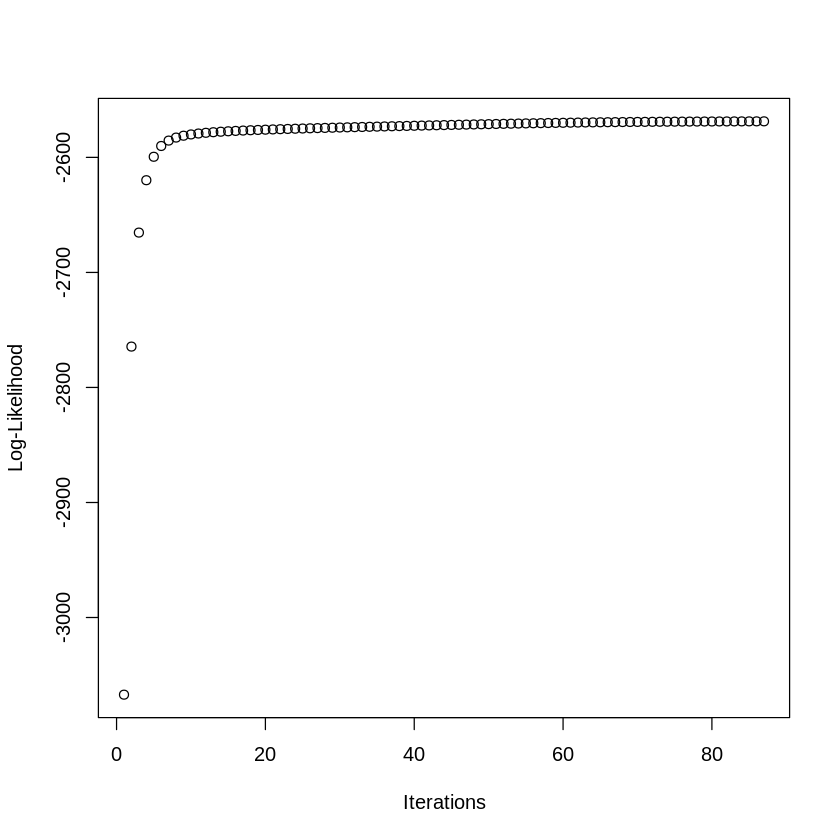

In [16]:
testMV3=MixCenMVReg_EM(Y=example_censored$Y,
                       X=example_censored$X,
                       C=example_censored$censorID, 
                       init_class=as.factor(testMV2$Class), # Note the input has to be a factor vector
                       Max.iter=1000, diff.tol=1e-2, print=T)

# Note, by assigning the same partitions as the last solution, 
# This will converge to exactly the same solution of 'testMV2'

Moreover, we can run a different model on the censored data, which ignores the covariate $X_1$. In this case, this model is reduced to a bivariate censored GMM model, we can do this by simply supressing the $X_1$ column and selecting only the $X_0$ in the design matrix input, so that only a bunch of 1s are left in the design matrix input. 

Here, because we are in reality ignoring the covariates, we can even use a kmeans clustering as the inital partition, it will be a worse initalization of course, and therefore, if compare with 'testMV3', it will need more iterations or come to a solution of a decreased log-likelihood, but more importantly, the clustering is likely to be biased:

[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 350"
[1] "Convergence = TRUE"
[1] "LogLik = -3538.773"
      pie1       pie2       pie3 
0.03435024 0.69891013 0.26673963 
$beta1
             Y1       Y2
[1,] -0.1580573 16.59046

$beta2
           Y1       Y2
[1,] 2.835766 26.62744

$beta3
           Y1       Y2
[1,] 3.377895 21.65745

$sigma1
          Y1        Y2
Y1 31.315294 -3.013621
Y2 -3.013621  2.466383

$sigma2
          Y1        Y2
Y1  2.654093 -1.393849
Y2 -1.393849  6.149251

$sigma3
           Y1         Y2
Y1  4.0225687 -0.3803099
Y2 -0.3803099  3.2910516



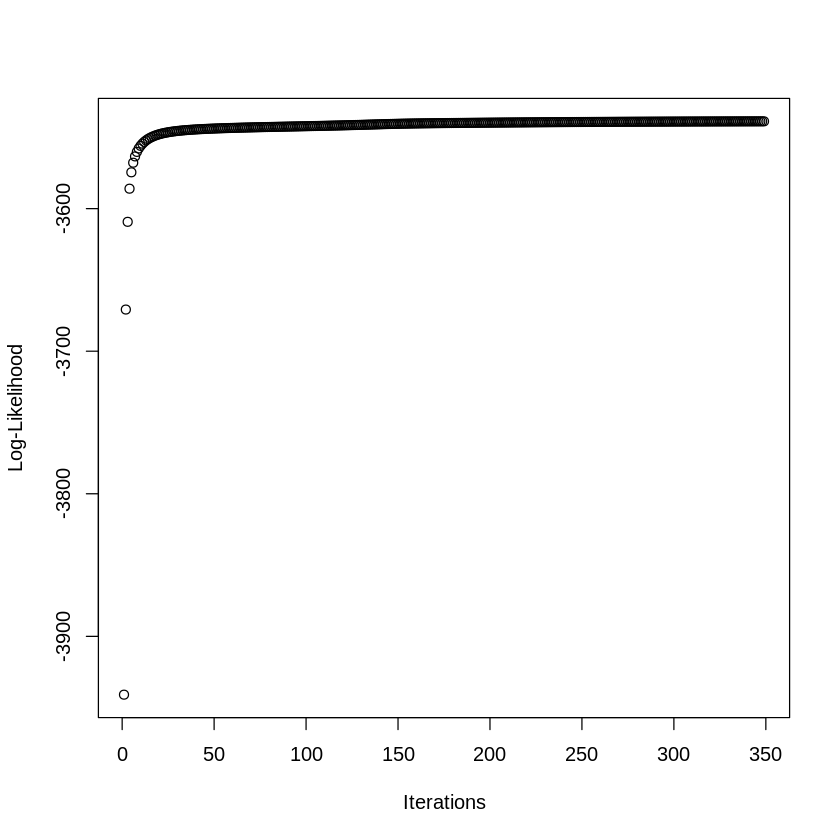

In [17]:
testMV4=MixCenMVReg_EM(Y=example_censored$Y,
                       X=example_censored$X[,1],
                       C=example_censored$censorID, 
                       init_class=as.factor(kmeans(example_censored$Y,3)$cluster), 
                       # Note: the input has to be a factor vector
                       Max.iter=1000, diff.tol=1e-2, print=T)

# Modeling using MixCensUVReg_EM.R

Now we can try run what we have tried before using only the one of the two responses, say $Y_2$

## Initialize from a given parameter setting

Let's initalize from the true parameters, so we expect the coverged estimates are going to be close to our true parameters.

Also, we can store and pass the model results to a variable and let the "print=TURE" argument only give us important info:

In [18]:
source(paste0(path,"/MixCenUVReg_EM.R")) # For univariate responses (dimenstion of Y=1)

[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 35"
[1] "Convergence = TRUE"
[1] "LogLik = -1361.781"
     pie1      pie2      pie3 
0.1064956 0.7037865 0.1897179 
$beta1
        [,1]
X0 20.246537
X1 -1.919477

$beta2
        [,1]
X0 24.981862
X1 -2.985659

$beta3
        [,1]
X0 30.657632
X1 -5.228493

$sigma1
[1] 1.226629

$sigma2
[1] 0.655458

$sigma3
[1] 1.494161



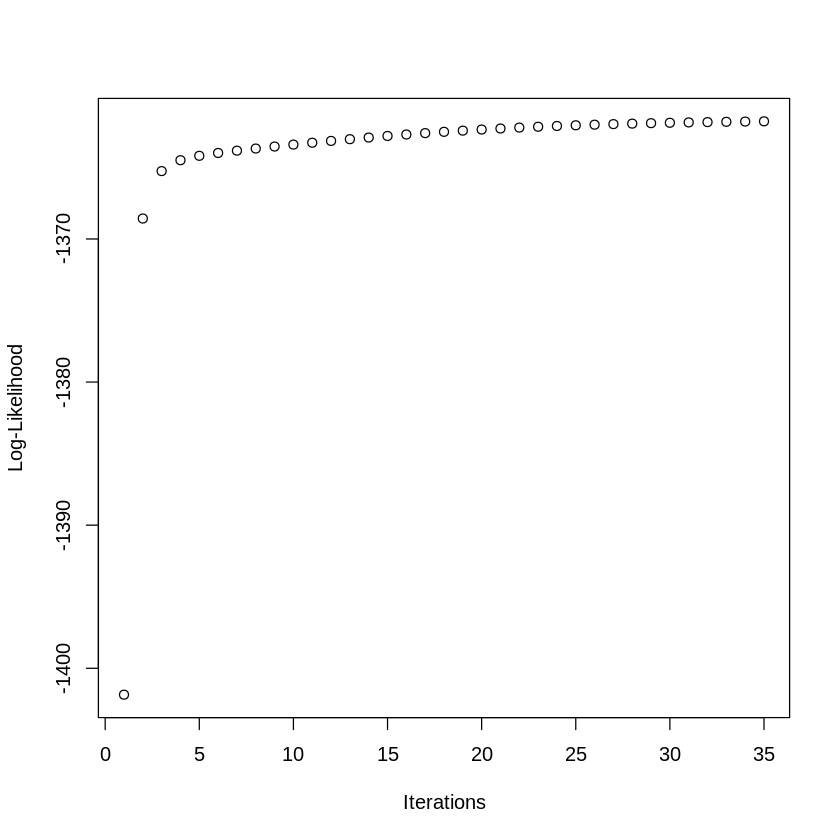

In [19]:
# Note in this case we do not need to set the number of components G=
# The algorithm will run as long as the length of the inital parameters agrees.
# Note how the estimated pies are similar to (0.1,0.7,0.2)
testUV1=MixCenUVReg_EM(Y=as.matrix(example_censored$Y[,2]),
                       X=example_censored$X,
                       C=as.matrix(example_censored$censorID[,2]), 
                       pie_hat=PIE, 
                       beta_hat=list(as.matrix(BETA[[1]][,2]),
                                     as.matrix(BETA[[2]][,2]),
                                     as.matrix(BETA[[3]][,2])), 
                       sigma_hat=list(as.matrix(SIGMA[[1]][2,2]),
                                      as.matrix(SIGMA[[2]][2,2]),
                                      as.matrix(SIGMA[[3]][2,2])), ,
                       Max.iter=1000, diff.tol=1e-2, print=T)

However, if we ignore the censoring by assuming all observations are uncensord, though it will be faster for computation, we will have a problem:

EM stopped becaused of degenerating solution!



[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 15"
[1] "Convergence = FALSE"
[1] "LogLik = 719.841"
     pie1      pie2      pie3 
0.2019652 0.4311354 0.3668994 
$beta1
        [,1]
X0 22.070025
X1 -1.005336

$beta2
        [,1]
X0 24.890768
X1 -2.874604

$beta3
           [,1]
X0 2.650000e+01
X1 1.519618e-15

$sigma1
[1] 2.65614

$sigma2
[1] 0.5988811

$sigma3
[1] 8.441815e-15



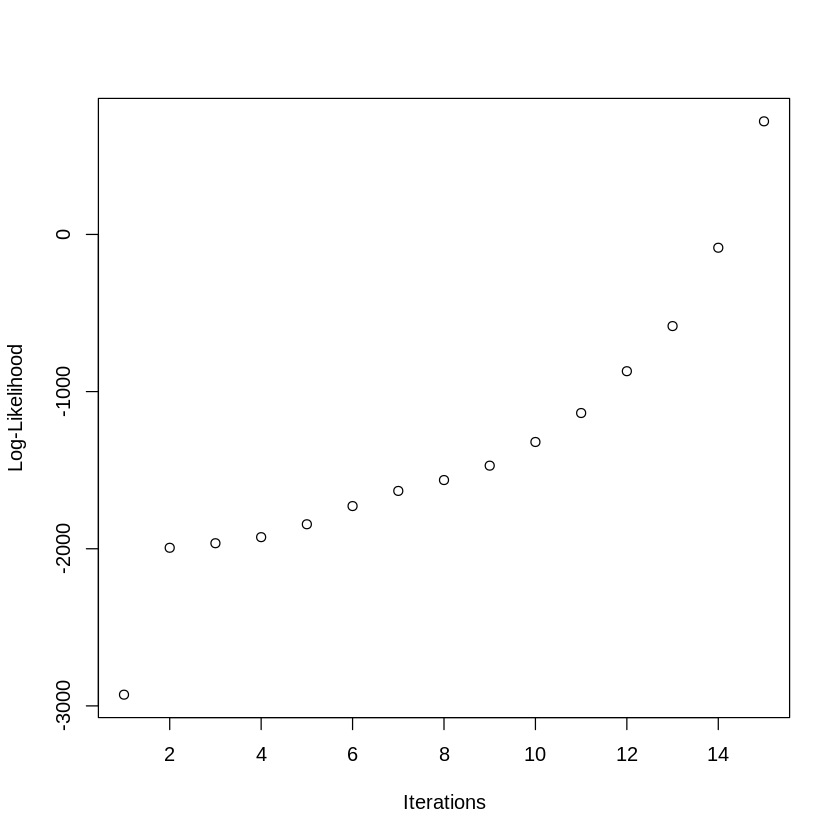

In [20]:
# Note in this case set the censoring 
# Note how the esimated mixing porportions are different than 'testMV1'
# ,even with the true parameter initialization (0,1,0.7,0.2)
# and most importantly we have a degenerated solution with one diagnal element of $sigma1 -->0
testUV1.2=MixCenUVReg_EM(Y=as.matrix(example_censored$Y[,2]),
                         X=example_censored$X,
                         C=as.matrix(example_censored$censorID[,2])*0, 
                         pie_hat=PIE, 
                         beta_hat=list(as.matrix(BETA[[1]][,2]),
                                       as.matrix(BETA[[2]][,2]),
                                       as.matrix(BETA[[3]][,2])), 
                         sigma_hat=list(as.matrix(SIGMA[[1]][2,2]),
                                        as.matrix(SIGMA[[2]][2,2]),
                                        as.matrix(SIGMA[[3]][2,2])), ,
                         Max.iter=1000, diff.tol=1e-2, print=T)

Even with the true parameter initialization, the estimated mixing porportions are so different than $(0,1,0.7,0.2)$. Note how the first mixing proportion is close the the censoring rate of $Y_1$ and most importantly we have a degenerated solution with one diagnal element of $\sigma_3\to0$:

In [21]:
testUV1.2$Sigma$sigma3

[1] 8.441815e-15

This is because when we ignore the censoring, the stacking observations at the detection limit will be recognized as a 'cluster', and because its all with the same values, it will result in a degenerating solution. However, we can use the true uncensored observations to train the model:

[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 7"
[1] "Convergence = TRUE"
[1] "LogLik = -1971.379"
     pie1      pie2      pie3 
0.1064684 0.6970537 0.1964779 
$beta1
        [,1]
X0 20.241229
X1 -1.902792

$beta2
        [,1]
X0 24.974738
X1 -2.970625

$beta3
        [,1]
X0 30.208631
X1 -4.933027

$sigma1
[1] 1.222204

$sigma2
[1] 0.6534271

$sigma3
[1] 1.553857



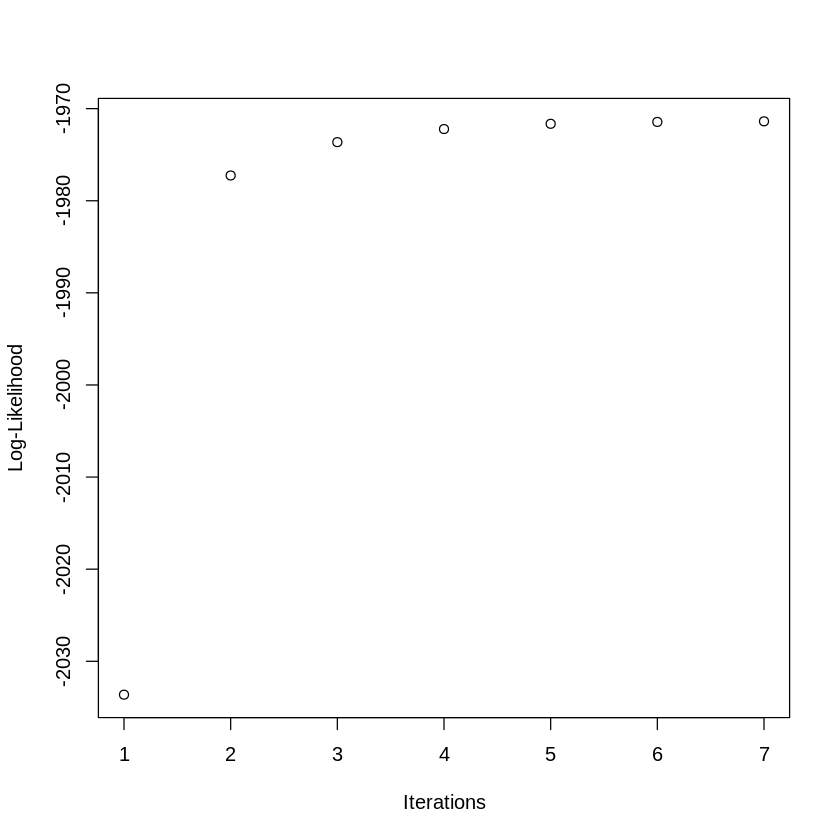

In [22]:
# Only thing change here is that we are using 'example_true' for the responses
# So we dont have any censoring, we can let the C=0 for all observations
testUV1.2=MixCenUVReg_EM(Y=as.matrix(example_true$Y[,2]),
                         X=example_censored$X,
                         C=as.matrix(example_censored$censorID[,2])*0, 
                         pie_hat=PIE, 
                         beta_hat=list(as.matrix(BETA[[1]][,2]),
                                       as.matrix(BETA[[2]][,2]),
                                       as.matrix(BETA[[3]][,2])), 
                         sigma_hat=list(as.matrix(SIGMA[[1]][2,2]),
                                        as.matrix(SIGMA[[2]][2,2]),
                                        as.matrix(SIGMA[[3]][2,2])), ,
                         Max.iter=1000, diff.tol=1e-2, print=T)

## initialize from a random initialization

We can start from a random partition, by just letting G=3, notice how this is different from the previous solution:

[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 66"
[1] "Convergence = TRUE"
[1] "LogLik = -1551.413"
     pie1      pie2      pie3 
0.5685815 0.1012641 0.3301544 
$beta1
        [,1]
X0 25.058877
X1 -3.122335

$beta2
        [,1]
X0 20.299332
X1 -1.801091

$beta3
       [,1]
X0 35.28708
X1 -9.07767

$sigma1
[1] 0.6717008

$sigma2
[1] 1.232262

$sigma3
[1] 2.491964



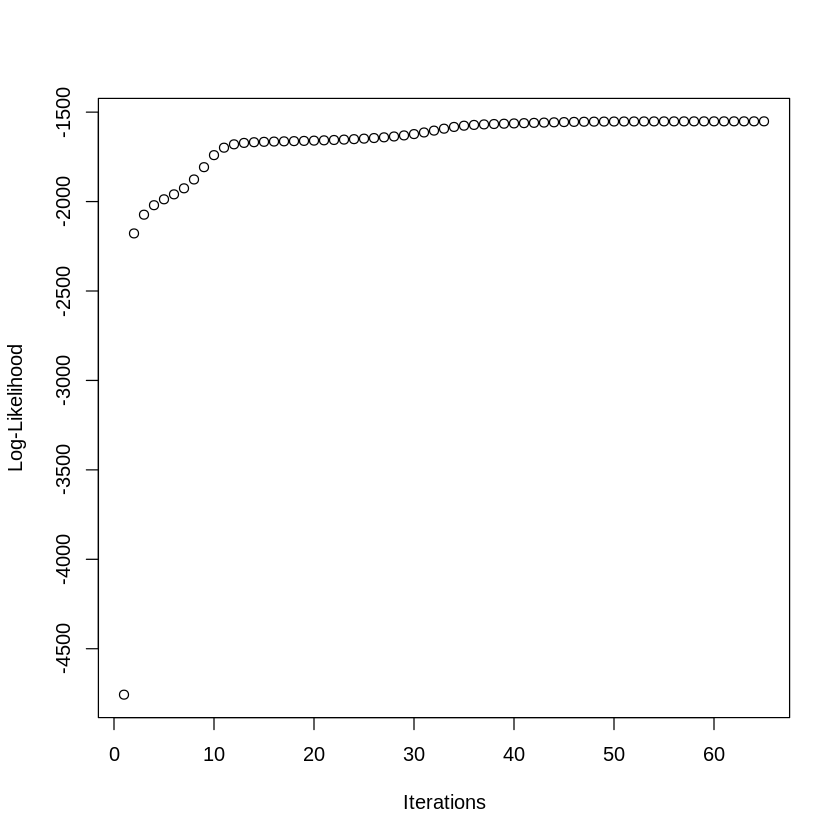

In [23]:
set.seed(123) 

# testUV2=MixCenUVReg_EM(Y=example_censored$Y,
#                        X=example_censored$X,
#                        C=example_censored$censorID, 
                       
                       
testUV2=MixCenUVReg_EM(Y=as.matrix(example_true$Y[,2]),
                       X=example_censored$X,
                       C=as.matrix(example_censored$censorID[,2]),                        
                       G=3,
                       Max.iter=1000, diff.tol=1e-2, print=T)

# Note that we may need to re-initialze this couple of times and pick the best result to have similar results as testUV1

## initialize from a given partition

Also, we can initialize the EM algorithm from a givn partition, how about the previous partition in 'testMV2' which is close to the truth?

[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 45"
[1] "Convergence = TRUE"
[1] "LogLik = -1551.415"
     pie1      pie2      pie3 
0.5682009 0.1013381 0.3304611 
$beta1
        [,1]
X0 25.058213
X1 -3.122547

$beta2
        [,1]
X0 20.298386
X1 -1.803026

$beta3
        [,1]
X0 35.098564
X1 -8.923252

$sigma1
[1] 0.6711345

$sigma2
[1] 1.23302

$sigma3
[1] 2.457715



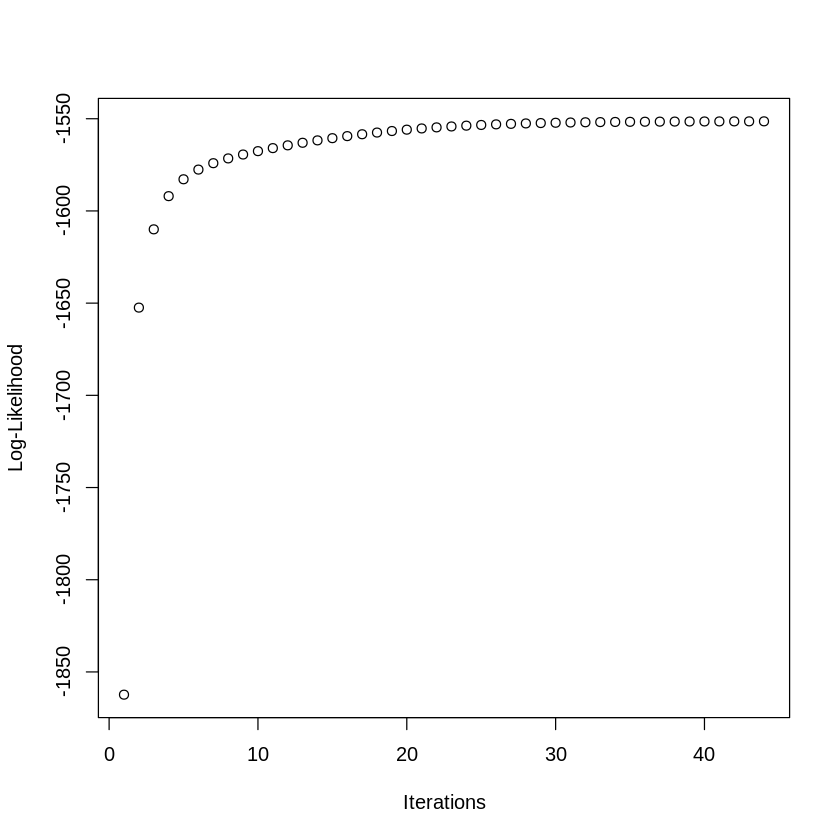

In [24]:
testUV3=MixCenUVReg_EM(Y=as.matrix(example_true$Y[,2]),
                       X=example_censored$X,
                       C=as.matrix(example_censored$censorID[,2]),   
                       init_class=as.factor(testUV2$Class), # Note the input has to be a factor vector
                       Max.iter=1000, diff.tol=1e-2, print=T)

# Note, by assigning the same partitions as the last solution, 
# This will converge to exactly the same solution of 'testUV2'

Moreover, we can run a different model on the censored data, which ignores the covariate $X_1$. In this case, this model is reduced to a bivariate censored GMM model, we can do this by simply supressing the $X_1$ column and selecting only the $X_0$ in the design matrix input, so that only a bunch of 1s are left in the design matrix input. 

Here, because we are in reality ignoring the covariates, we can even use a kmeans clustering as the inital partition, it will be a worse initalization of course, and therefore, if compare with 'testMV3', it will need more iterations or come to a solution of a decreased log-likelihood, but more importantly, the clustering is likely to be biased:

[1] "The Info matrix for coefficients is not computed"
[1] "Total Iteration = 58"
[1] "Convergence = TRUE"
[1] "LogLik = -1413.311"
      pie1       pie2       pie3 
0.61852876 0.32799519 0.05347605 
$beta1
        [,1]
X0 25.007043
X1 -3.002672

$beta2
        [,1]
X0 24.658668
X1 -2.638099

$beta3
         [,1]
X0 27.5043524
X1 -0.9147474

$sigma1
[1] 0.5979629

$sigma2
[1] 3.74216

$sigma3
[1] 0.3453054



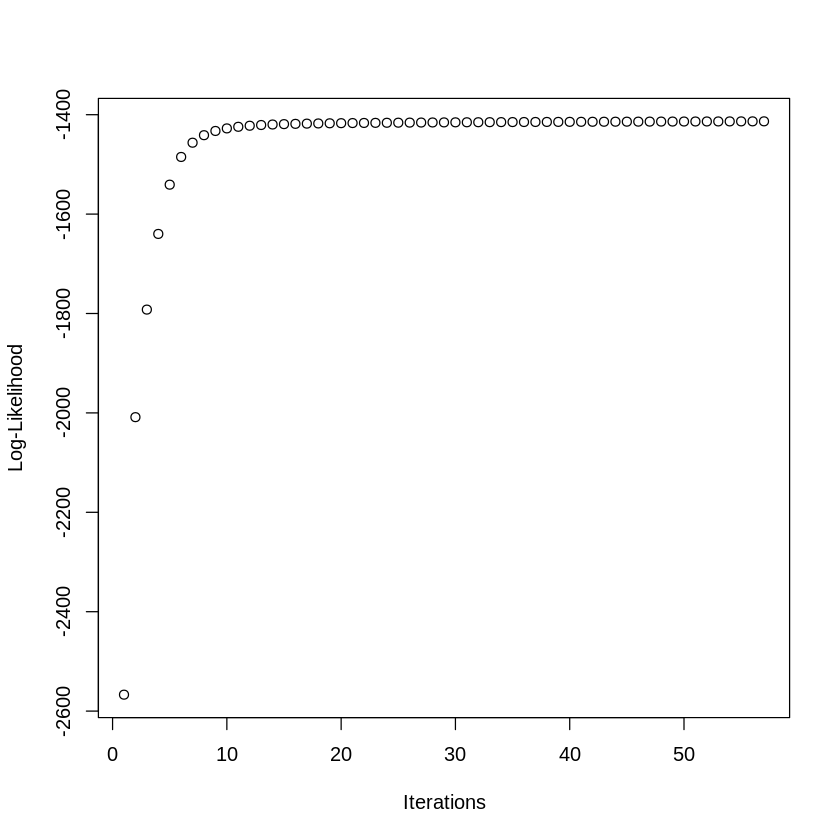

In [25]:
testUV4=MixCenUVReg_EM(Y=as.matrix(example_censored$Y[,2]),
                       X=example_censored$X,
                       C=as.matrix(example_censored$censorID[,2]), 
                       init_class=as.factor(kmeans(example_censored$Y,3)$cluster), 
                       # Note: the input has to be a factor vector
                       Max.iter=1000, diff.tol=1e-2, print=T)